# conseption et realisation d'un dashbord et d'un modele de detection de fraude des données de la Direction des Grandes Entreprise

## Preparation des données

### Importation des modules 

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools


### parametrages des modules 

In [2]:
sns.set_theme()
#pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

### selection, affichage et filtrage des fichiers

In [3]:
TVA = pd.read_excel('VraiTVA.xlsx')
#TVA

In [4]:
ERA = pd.read_excel('VraiERA.xlsx')
#ERA

In [5]:
jointure = pd.merge(ERA, TVA, on='BP', how='inner')
#jointure = jointure[['BP', 'Wilaya', 'Code CNRC', 'Code ONS', 'Chiffre d’affaire (C.A)', 'Total TVA anuelle']]  

In [6]:
jointure.rename(columns={'Chiffre d’affaire (C.A)': 'ChAff'}, inplace=True)
jointure.rename(columns={'Total TVA anuelle': 'Total TVA anunelle'}, inplace=True)
#jointure.head()

### créer la colonne feature et cible


In [7]:
jointure['feature'] =  jointure['ChAff']  - jointure['Total TVA anunelle'] 

In [8]:
def estime(row):
    if row['ChAff'] == 0 :
        return 'sus'
    elif abs(row['feature']) > 0.2 * row['ChAff']:
        return 'fraude'
    else:
        return 'bon'

jointure['cible'] = jointure.apply(estime, axis=1)

In [9]:
jointure.head()

,BP,Wilaya,Code CNRC,Code ONS,ChAff,Total TVA Janvier,Total TVA Février,Total TVA Mars,Total TVA Avril,Total TVA Mai,Total TVA Juin,Total TVA Juillet,Total TVA Août,Total TVA Septembre,Total TVA Octobre,Total TVA Novembre,Total TVA Décembre,Total TVA anunelle,feature,cible
0,2000000147,DIW Alger est,607047,/,0,4.381490e+09,4.710011e+09,5.358351e+09,4.811742e+09,4.835182e+09,4.467203e+09,3.692317e+09,3.713033e+09,5.274394e+09,6.056911e+09,4.706919e+09,5.852010e+09,5.785956e+10,-5.785956e+10,sus
1,2000000200,DIW Alger est,608001,/,93115698,6.441810e+05,1.478702e+06,2.304256e+06,1.226741e+06,2.147761e+07,3.343922e+07,9.184847e+06,4.261077e+06,3.033041e+06,4.966790e+06,5.425418e+06,5.673810e+06,9.311570e+07,0.000000e+00,bon
2,2000007178,DIW Bordj Bou Arréridj,110202,/,155423274,4.872747e+06,4.275042e+06,3.918504e+06,6.082352e+06,7.774514e+06,2.706730e+07,2.240796e+07,8.738202e+06,5.113770e+06,5.666626e+06,2.643794e+07,3.306832e+07,1.554233e+08,0.000000e+00,bon
3,2000009570,DIW Alger est,405105,/,5798168362,4.232086e+08,3.965581e+08,4.111293e+08,6.288660e+08,3.132802e+08,4.100639e+08,3.332674e+08,5.615210e+08,7.133190e+08,4.950724e+08,5.964098e+08,5.272515e+08,5.809947e+09,-1.177863e+07,bon
4,2000011509,DIW Alger est,409001,/,2062602782,1.607687e+08,2.937824e+08,3.321080e+08,1.234689e+08,1.051586e+08,2.330517e+08,1.305186e+08,1.720886e+08,1.598969e+08,1.437596e+08,7.488136e+07,1.328862e+08,2.062370e+09,2.331380e+05,bon


## Over sample de la donnée fraude dans le data set

In [10]:

fraud_count = jointure['cible'].value_counts()
print(fraud_count)

#definir la donnée maximal et minimal
minority_cible = fraud_count.idxmin()
majority_cible = fraud_count.idxmax()

# Calcule du nombre de rows à add
oversample_amount = fraud_count[majority_cible] - fraud_count[minority_cible]



cible
bon       669
fraude    371
sus       230
Name: count, dtype: int64


In [11]:
# Filter the minority class
minority_data = jointure[jointure['cible'] == minority_cible]

# Randomly sample from the minority data
oversampled_data = minority_data.sample(n=oversample_amount, replace=True, random_state=42)

# Append the oversampled data to the original DataFrame
jointure_oversampled = pd.concat([jointure, oversampled_data])

# Shuffle the dataset to mix the rows up
jointure_oversampled = jointure_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)


### Verification du nouveau data set

In [12]:
print(jointure_oversampled['cible'].value_counts())

cible
sus       669
bon       669
fraude    371
Name: count, dtype: int64


In [13]:
print(jointure_oversampled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BP                   1709 non-null   int64  
 1   Wilaya               1709 non-null   object 
 2   Code CNRC            1709 non-null   object 
 3   Code ONS             1709 non-null   object 
 4   ChAff                1709 non-null   int64  
 5   Total TVA Janvier    1709 non-null   float64
 6   Total TVA Février    1709 non-null   float64
 7   Total TVA Mars       1709 non-null   float64
 8   Total TVA Avril      1709 non-null   float64
 9   Total TVA Mai        1709 non-null   float64
 10  Total TVA Juin       1709 non-null   float64
 11  Total TVA Juillet    1709 non-null   float64
 12  Total TVA Août       1709 non-null   float64
 13  Total TVA Septembre  1709 non-null   float64
 14  Total TVA Octobre    1709 non-null   float64
 15  Total TVA Novembre   1709 non-null   f

## Encodage categoriel & Normalisation/Standardisation 

### encodage categoriel des wilaya

In [14]:
wilaya_count = jointure_oversampled['Wilaya'].value_counts()
print(wilaya_count)

Wilaya
DIW Alger centre          729
DIW Alger est             235
DIW Alger ouest           184
DIW Oran Est               80
DIW Ouargla                68
DIW Blida                  58
DIW Constantine            44
DIW Sétif                  34
DIW Boumerdès              30
DIW Béjaïa                 29
DIW Sidi Bel Abbes         23
DIW Annaba                 20
DIW Bordj Bou Arréridj     15
DIW Skikda                 14
DIW Batna                  14
DIW Tlemcen                13
DIW Tizi Ouzou             10
DIW Mila                    9
DIW Tipaza                  9
DIW Bouira                  8
DIW Chlef                   8
DIW Relizane                8
DIW Oran Ouest              7
DIW Mostaganem              7
DIW M'Sila                  7
DIW Jijel                   6
DIW Biskra                  6
Non affecté                 6
DIW Oum el-Bouaghi          5
DIW Médéa                   3
DIW Aïn Témouchent          3
DIW Mascara                 3
DIW Tiaret                  2
DIW

In [15]:
# Clean and standardize the Wilaya names
jointure_oversampled['Standardized_Wilaya'] = jointure_oversampled['Wilaya'].str.replace('DIW ', '')

# Label Encoding
wilaya_mapping = {name: i + 1 for i, name in enumerate(jointure_oversampled['Standardized_Wilaya'].unique())}
jointure_oversampled['Wilaya_encoded'] = jointure_oversampled['Standardized_Wilaya'].map(wilaya_mapping)

# Display the DataFrame to check the new columns
print(jointure_oversampled[['Wilaya', 'Standardized_Wilaya', 'Wilaya_encoded']])

                  Wilaya Standardized_Wilaya  Wilaya_encoded
0     DIW Sidi Bel Abbes      Sidi Bel Abbes               1
1       DIW Alger centre        Alger centre               2
2        DIW Alger ouest         Alger ouest               3
3          DIW Alger est           Alger est               4
4          DIW Alger est           Alger est               4
...                  ...                 ...             ...
1704    DIW Alger centre        Alger centre               2
1705    DIW Alger centre        Alger centre               2
1706     DIW Alger ouest         Alger ouest               3
1707     DIW Alger ouest         Alger ouest               3
1708        DIW Relizane            Relizane               6

[1709 rows x 3 columns]


### encodage categoriel des Codes ONS et CNRC

In [16]:
# Label Encoding for 'code CNRC'
cnrc_unique = pd.unique(jointure_oversampled['Code CNRC'])
code_cnrc_mapping = {code: idx + 1 for idx, code in enumerate(cnrc_unique)}
jointure_oversampled['code CNRC_encoded'] = jointure_oversampled['Code CNRC'].map(code_cnrc_mapping)

# Label Encoding for 'code ONS'
ons_unique = pd.unique(jointure_oversampled['Code ONS'])
code_ons_mapping = {code: idx + 1 for idx, code in enumerate(ons_unique)}
jointure_oversampled['code ONS_encoded'] = jointure_oversampled['Code ONS'].map(code_ons_mapping)

# Display the DataFrame to check the new columns
print(jointure_oversampled)

              BP              Wilaya Code CNRC Code ONS      ChAff  \
0     2000045399  DIW Sidi Bel Abbes         /        /          0   
1     2000045867    DIW Alger centre    102102     4321          0   
2     2000046488     DIW Alger ouest         /        /          0   
3     2000044699       DIW Alger est    103103        /  838526717   
4     2000045234       DIW Alger est         /        /          0   
...          ...                 ...       ...      ...        ...   
1704  2000046633    DIW Alger centre    613125     4321   22988920   
1705  2000046541    DIW Alger centre    613125     4321          0   
1706  2000045829     DIW Alger ouest         /        /  113184009   
1707  2000046552     DIW Alger ouest    613203     4329          0   
1708  2000046628        DIW Relizane    613203     4329          0   

      Total TVA Janvier  Total TVA Février  Total TVA Mars  Total TVA Avril  \
0          1.958626e+09       1.813410e+09    1.867400e+09     2.031599e+09   
1

### encodage categoriel de target ENFIN

In [17]:
target_mapping = {
    'bon': 0,      # Typically, the "normal" class can be zero
    'fraude': 1,   # Positive class can be one, especially if it's a binary classification
    'sus': 2       # Additional class can take the next integer
}

# Apply the mapping to the target column
jointure_oversampled['target_encoded'] = jointure_oversampled['cible'].map(target_mapping)

# Display the DataFrame to check the new column
print(jointure_oversampled[['cible', 'target_encoded']])

       cible  target_encoded
0        sus               2
1        sus               2
2        sus               2
3        bon               0
4        sus               2
...      ...             ...
1704  fraude               1
1705     sus               2
1706  fraude               1
1707     sus               2
1708     sus               2

[1709 rows x 2 columns]


### verification du Data set :SOB: + supression des columns not needed 

In [18]:
jointure_oversampled

,BP,Wilaya,Code CNRC,Code ONS,ChAff,Total TVA Janvier,Total TVA Février,Total TVA Mars,Total TVA Avril,Total TVA Mai,Total TVA Juin,Total TVA Juillet,Total TVA Août,Total TVA Septembre,Total TVA Octobre,Total TVA Novembre,Total TVA Décembre,Total TVA anunelle,feature,cible,Standardized_Wilaya,Wilaya_encoded,code CNRC_encoded,code ONS_encoded,target_encoded
0,2000045399,DIW Sidi Bel Abbes,/,/,0,1.958626e+09,1.813410e+09,1.867400e+09,2.031599e+09,2.153525e+09,2.191206e+09,1.305699e+09,1.180612e+09,1.526498e+09,2.681394e+09,1.298003e+09,2.209720e+09,2.221769e+10,-2.221769e+10,sus,Sidi Bel Abbes,1,1,1,2
1,2000045867,DIW Alger centre,102102,4321,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,sus,Alger centre,2,2,2,2
2,2000046488,DIW Alger ouest,/,/,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,sus,Alger ouest,3,1,1,2
3,2000044699,DIW Alger est,103103,/,838526717,7.900464e+07,6.374161e+07,8.521569e+07,6.320110e+07,4.088590e+07,6.831483e+07,1.348191e+08,7.720119e+07,8.304980e+07,9.323792e+07,6.313974e+07,5.412466e+07,9.059362e+08,-6.740948e+07,bon,Alger est,4,3,1,0
4,2000045234,DIW Alger est,/,/,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,sus,Alger est,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,2000046633,DIW Alger centre,613125,4321,22988920,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.954700e+06,2.954700e+06,2.003422e+07,fraude,Alger centre,2,7,2,1
1705,2000046541,DIW Alger centre,613125,4321,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,sus,Alger centre,2,7,2,2
1706,2000045829,DIW Alger ouest,/,/,113184009,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.131840e+08,fraude,Alger ouest,3,1,1,1
1707,2000046552,DIW Alger ouest,613203,4329,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,sus,Alger ouest,3,5,3,2


In [19]:
print(jointure_oversampled.columns)

Index(['BP', 'Wilaya', 'Code CNRC', 'Code ONS', 'ChAff', 'Total TVA Janvier',
       'Total TVA Février', 'Total TVA Mars', 'Total TVA Avril',
       'Total TVA Mai', 'Total TVA Juin', 'Total TVA Juillet',
       'Total TVA Août', 'Total TVA Septembre', 'Total TVA Octobre',
       'Total TVA Novembre', 'Total TVA Décembre', 'Total TVA anunelle',
       'feature', 'cible', 'Standardized_Wilaya', 'Wilaya_encoded',
       'code CNRC_encoded', 'code ONS_encoded', 'target_encoded'],
      dtype='object')


In [20]:
jointure_oversampled = jointure_oversampled.drop(columns = ['Wilaya', 'Code CNRC', 'Code ONS','cible'])

In [21]:
jointure_oversampled = jointure_oversampled.drop(columns = ['Standardized_Wilaya'])

In [22]:
jointure_oversampled

,BP,ChAff,Total TVA Janvier,Total TVA Février,Total TVA Mars,Total TVA Avril,Total TVA Mai,Total TVA Juin,Total TVA Juillet,Total TVA Août,Total TVA Septembre,Total TVA Octobre,Total TVA Novembre,Total TVA Décembre,Total TVA anunelle,feature,Wilaya_encoded,code CNRC_encoded,code ONS_encoded,target_encoded
0,2000045399,0,1.958626e+09,1.813410e+09,1.867400e+09,2.031599e+09,2.153525e+09,2.191206e+09,1.305699e+09,1.180612e+09,1.526498e+09,2.681394e+09,1.298003e+09,2.209720e+09,2.221769e+10,-2.221769e+10,1,1,1,2
1,2000045867,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2,2,2,2
2,2000046488,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,1,1,2
3,2000044699,838526717,7.900464e+07,6.374161e+07,8.521569e+07,6.320110e+07,4.088590e+07,6.831483e+07,1.348191e+08,7.720119e+07,8.304980e+07,9.323792e+07,6.313974e+07,5.412466e+07,9.059362e+08,-6.740948e+07,4,3,1,0
4,2000045234,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,2000046633,22988920,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.954700e+06,2.954700e+06,2.003422e+07,2,7,2,1
1705,2000046541,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2,7,2,2
1706,2000045829,113184009,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.131840e+08,3,1,1,1
1707,2000046552,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,5,3,2


### normalisation et standardisation 
 vu que nous allons faire a random forest and/or a regression tree, il serait preferable de standardiser les données 

In [23]:
jointure_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BP                   1709 non-null   int64  
 1   ChAff                1709 non-null   int64  
 2   Total TVA Janvier    1709 non-null   float64
 3   Total TVA Février    1709 non-null   float64
 4   Total TVA Mars       1709 non-null   float64
 5   Total TVA Avril      1709 non-null   float64
 6   Total TVA Mai        1709 non-null   float64
 7   Total TVA Juin       1709 non-null   float64
 8   Total TVA Juillet    1709 non-null   float64
 9   Total TVA Août       1709 non-null   float64
 10  Total TVA Septembre  1709 non-null   float64
 11  Total TVA Octobre    1709 non-null   float64
 12  Total TVA Novembre   1709 non-null   float64
 13  Total TVA Décembre   1709 non-null   float64
 14  Total TVA anunelle   1709 non-null   float64
 15  feature              1709 non-null   f

In [24]:
columns_to_standardize = [
    'ChAff',
    'Total TVA Janvier', 'Total TVA Février', 'Total TVA Mars', 'Total TVA Avril',
    'Total TVA Mai', 'Total TVA Juin', 'Total TVA Juillet', 'Total TVA Août',
    'Total TVA Septembre', 'Total TVA Octobre', 'Total TVA Novembre', 'Total TVA Décembre',
    'Total TVA anunelle'
]

# Apply standardization
for column in columns_to_standardize:
    jointure_oversampled[column] = (jointure_oversampled[column] - jointure_oversampled[column].mean()) / jointure_oversampled[column].std()

# Now your columns are standardized
print(jointure_oversampled[columns_to_standardize].head())

      ChAff  Total TVA Janvier  Total TVA Février  Total TVA Mars  \
0 -0.055971           0.574705           0.645778        0.581130   
1 -0.055971          -0.168711          -0.183681       -0.193220   
2 -0.055971          -0.168711          -0.183681       -0.193220   
3 -0.052058          -0.138724          -0.154525       -0.157884   
4 -0.055971          -0.168711          -0.183681       -0.193220   

   Total TVA Avril  Total TVA Mai  Total TVA Juin  Total TVA Juillet  \
0         0.655551       0.652536        0.719614           0.390718   
1        -0.174768      -0.177589       -0.186745          -0.175976   
2        -0.174768      -0.177589       -0.186745          -0.175976   
3        -0.148938      -0.161828       -0.158487          -0.117463   
4        -0.174768      -0.177589       -0.186745          -0.175976   

   Total TVA Août  Total TVA Septembre  Total TVA Octobre  Total TVA Novembre  \
0        0.309813             0.455276           0.892869            0.

In [25]:
jointure_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BP                   1709 non-null   int64  
 1   ChAff                1709 non-null   float64
 2   Total TVA Janvier    1709 non-null   float64
 3   Total TVA Février    1709 non-null   float64
 4   Total TVA Mars       1709 non-null   float64
 5   Total TVA Avril      1709 non-null   float64
 6   Total TVA Mai        1709 non-null   float64
 7   Total TVA Juin       1709 non-null   float64
 8   Total TVA Juillet    1709 non-null   float64
 9   Total TVA Août       1709 non-null   float64
 10  Total TVA Septembre  1709 non-null   float64
 11  Total TVA Octobre    1709 non-null   float64
 12  Total TVA Novembre   1709 non-null   float64
 13  Total TVA Décembre   1709 non-null   float64
 14  Total TVA anunelle   1709 non-null   float64
 15  feature              1709 non-null   f

In [26]:
import numpy as np

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Usage
from collections import Counter
from sklearn.model_selection import train_test_split

# Assuming 'jointure_oversampled' is your DataFrame and you want to predict 'target_encoded' using k-NN

# Convert DataFrame to numpy array for easier manipulation
X = jointure_oversampled.drop(columns=['target_encoded']).values
y = jointure_oversampled['target_encoded'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the k-NN classifier
knn = KNN(k=3)
knn.fit(X_train, y_train)

# Making predictions on the test set
predictions = knn.predict(X_test)

# Evaluating the model
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.75


In [27]:
from collections import Counter

def precision_recall_f1(y_true, y_pred):
    # Calculate precision and recall for each class
    classes = np.unique(y_true)
    precision = {}
    recall = {}
    f1 = {}
    support = Counter(y_true)
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        tp_fp = np.sum(y_pred == cls)
        tp_fn = np.sum(y_true == cls)
        
        precision[cls] = tp / tp_fp if tp_fp > 0 else 0
        recall[cls] = tp / tp_fn if tp_fn > 0 else 0
        f1[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if (precision[cls] + recall[cls]) > 0 else 0
    
    return precision, recall, f1, support

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Example usage:
precision, recall, f1, support = precision_recall_f1(y_test, predictions)
acc = accuracy(y_test, predictions)

print("Class\tPrecision\tRecall\tF1-Score\tSupport")
for cls in np.unique(y_test):
    print(f"{cls}\t{precision[cls]:.2f}\t\t{recall[cls]:.2f}\t{f1[cls]:.2f}\t\t{support[cls]}")

print(f"\nAccuracy: {acc:.2f}")


Class	Precision	Recall	F1-Score	Support
0	0.66		0.62	0.64		111
1	0.75		0.58	0.65		76
2	0.80		0.93	0.86		155

Accuracy: 0.75


In [28]:
def compute_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(classes)):
        for j in range(len(classes)):
            matrix[i, j] = np.sum((y_true == classes[i]) & (y_pred == classes[j]))
    return matrix


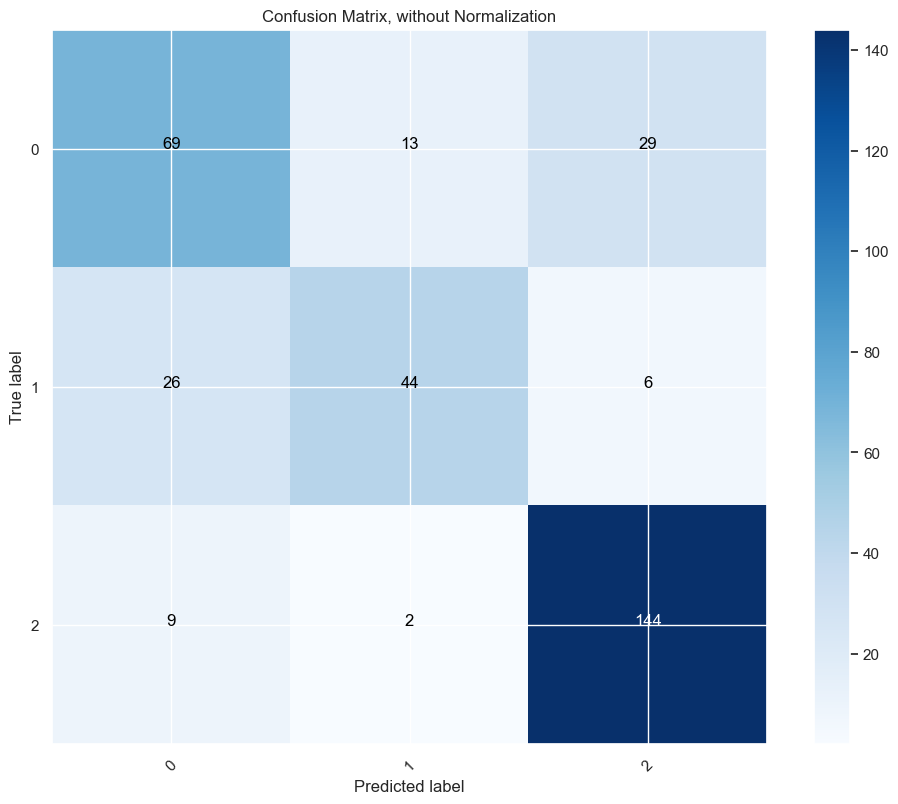

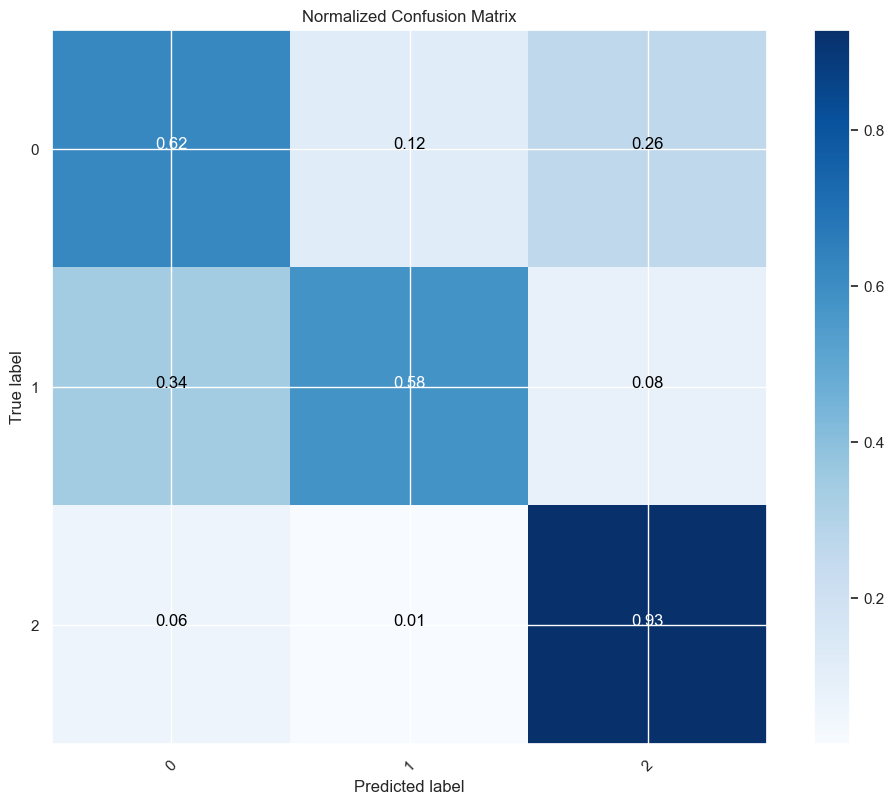

In [30]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=np.unique(y_test),
                      title='Confusion Matrix, without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=np.unique(y_test), normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()
